In [1]:

import torch

from editing_diffusion.llm_objects import spot_objects
from editing_diffusion.detectors.owlvitv2 import OWLViTv2Detector
from editing_diffusion.editing import post_process, show_attention, CustomAttentionProcessor
from editing_diffusion.editing.edits import position

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and tokenizer names
model_name = "google/gemma-7b-it" #"mistralai/Mistral-7B-Instruct-v0.1" #"google/gemma-7b-it" #"mistralai/Mistral-7B-Instruct-v0.1"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
model_params = {
    #"max_length": 1200,  # Maximum length of generated text
    "max_new_tokens": 200,
    #"temperature": 0.7,  # Controls randomness (higher -> more random)
    #"top_k": 50, 
}

In [4]:
prompts = [
    "a realistic cartoon-style image with a princess and four dwarfs",
    "a vivid photo with a woman on the right and a clown on the left walking in a dirty alley",
    "a monkey sitting above a green motorcycle on the left and another raccoon sitting above a blue motorcycle on the right",
    "a photo of a giant macaron and a croissant splashing in the Seine with the Eiffel Tower in the background",
    "a DSLR photo of a meatball and a donut falling from the clouds onto a neighborhood",
]
results = []
for prompt in prompts:
    result = spot_objects(tokenizer, model, prompt, device, **model_params)
    results.append(result)

In [6]:
from editing_diffusion.diffusion_models import SDXLEditingPipeline

In [7]:
import diffusers
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Using DDPM as scheduler.


In [8]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from diffusers.models.attention_processor import Attention

In [9]:
from functools import partial
_SG_RES = 64
save_aux=True 

attn_greenlist = []
for i in range(len(base.unet.up_blocks)-2):
   for j in range(len(base.unet.up_blocks[i].attentions)):
      base_name = f"up_blocks.{i}.attentions.{j}.transformer_blocks"
      for name, module in base.unet.up_blocks[i].attentions[j].transformer_blocks.named_children():
        for name_child, module_child in module.named_children():
          if name_child == "attn2":
              attn_greenlist.append(base_name+f".{name}.{name_child}")
for name, block in base.unet.named_modules():
    if isinstance(block, (diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, diffusers.models.unet_2d_blocks.UNetMidBlock2DCrossAttn)):
        for attn_name, attn in block.named_modules():
            full_name = name+'.'+attn_name
            if 'attn2' not in attn_name or (attn_greenlist and full_name not in attn_greenlist): 
                continue
            if isinstance(attn, diffusers.models.attention_processor.Attention):
                if isinstance(attn.processor, diffusers.models.attention_processor.AttnProcessor2_0):
                    attn.processor = CustomAttentionProcessor(_SG_RES, save_aux)
                else:
                    raise NotImplementedError("Self-guidance is not implemented for this attention processor")
          
def resave_aux_key(module, *args, old_key="attn", new_key="last_attn"):
    module._aux[new_key] = module._aux[old_key]

def resize(x):
    return TF.resize(x, _SG_RES, antialias=True)

def stash_to_aux(module, args, kwargs, output, mode, key="last_feats", args_idx=None, kwargs_key=None, fn_to_run=None):
    to_save = None
    if mode == "args":
        to_save = input
        if args_idx is not None:
            to_save = args[args_idx]
    elif mode == "kwargs":
        assert kwargs_key is not None
        to_save = kwargs[kwargs_key]
    elif mode == "output":
        to_save = output
    if fn_to_run is not None:
        to_save = fn_to_run(to_save)
    try:
        global save_aux
        if not save_aux:
            len_ = len(module._aux[key])
            del module._aux[key]
            module._aux[key] = [None]*len_ + [to_save]
        else:
            module._aux[key][-1] = module._aux[key][-1].cpu()
            module._aux[key].append(to_save)
    except:
      try:
          del module._aux[key]
      except:
          pass
      module._aux = {key: [to_save]}

# base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="kwargs", kwargs_key="hidden_states"), with_kwargs=True)
handle1 = base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="output"), with_kwargs=True)
# base.unet.up_blocks[1].resnets[1].conv2.register_forward_hook(partial(stash_to_aux,mode="args", args_idx=0), with_kwargs=True)
handle2 = base.unet.up_blocks[0].attentions[1].transformer_blocks[3].attn2.register_forward_hook(resave_aux_key)

In [10]:
seed = 1

In [11]:
generator = torch.Generator(device=device1).manual_seed(seed)
n_img=1

In [12]:
save_aux=True # @param {type:"boolean"}
n_img=1  # @param {type:"integer"}

out = base(prompt=[prompts[2]]*n_img, num_inference_steps=300, generator=generator, save_aux=save_aux, latents=None)
if save_aux: 
    aux = base.get_sg_aux()

  0%|          | 0/300 [00:00<?, ?it/s]

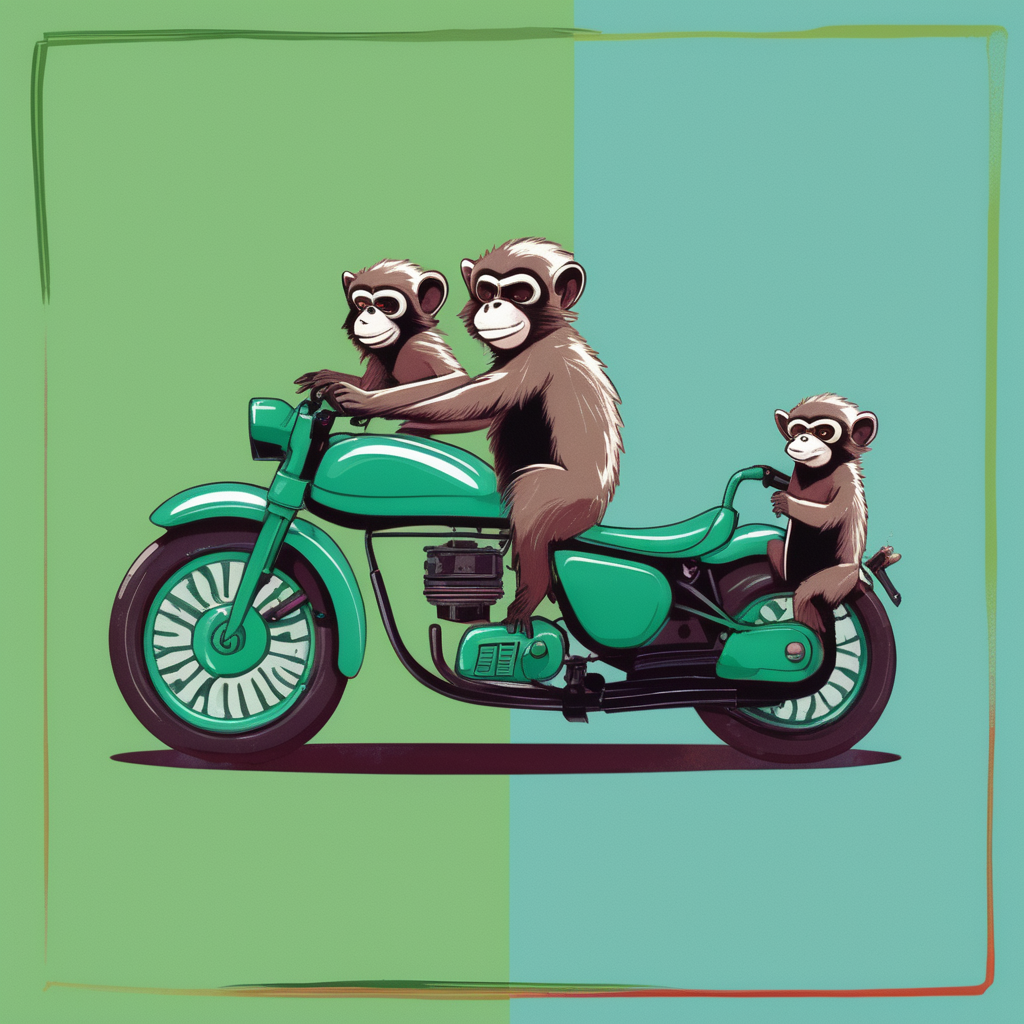

In [13]:
out.images[0]

In [14]:
processed_aux = post_process(aux)

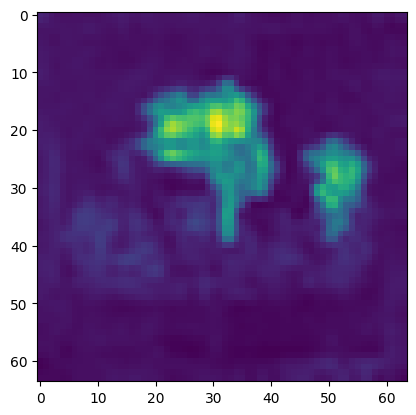

In [15]:
import matplotlib.pyplot as plt
result_attention = show_attention(base, processed_aux, prompts[2], "monkey", attn_greenlist, 279)
plt.imshow(result_attention['up_blocks.0.attentions.1.transformer_blocks.1.attn2'])

In [16]:
detector = OWLViTv2Detector(device)

In [17]:
results_detection = detector(results[2]["objects"], out.images[0], device, 0.5, 0.3, 0.4)

In [18]:
width, height = 64, 64
results_new_detection = {}
for name, bboxes in results_detection.items():
    bboxes_new = []
    for bbox in bboxes:
        x1, y1, w, h = bbox
        x2 = x1 + w
        y2 = y1 + h
        x1 *= width
        x2 *= width
        y1 *= height
        y2 *= height
        bboxes_new.append([int(x1), int(y1), int(x2), int(y2)])
    results_new_detection[name] = bboxes_new
results_new_detection

{'green motorcycle': [[6, 24, 55, 47]],
 'monkey': [[47, 24, 54, 40], [19, 15, 38, 39], [18, 16, 29, 26]]}

In [19]:
width, height = out.images[0].size

In [20]:
from PIL import ImageDraw, ImageFont

In [21]:
img = out.images[0].copy()
draw = ImageDraw.Draw(img)
object_count = {}
for name, box_list in results_detection.items():
    for box in box_list:
        x1, y1, w, h = box
        x2 = x1 + w
        y2 = y1 + h
        x1 *= width
        x2 *= width
        y1 *= height
        y2 *= height
        draw.rectangle(((int(x1), int(y1)), (int(x2), int(y2))), outline=(255, 0, 0))
        font = ImageFont.load_default(size=20)
    
        text_size = draw.textbbox((0, 0), f"{name}, id={object_count.get(name, 0)}", font=font)
    
        text_position = (x1, max(y1 - text_size[3] - 2, 0))
        draw.text(text_position, f"{name}, id={object_count.get(name, 0)}", fill='white', font=font)
        object_count[name] = object_count.get(name, 0) + 1


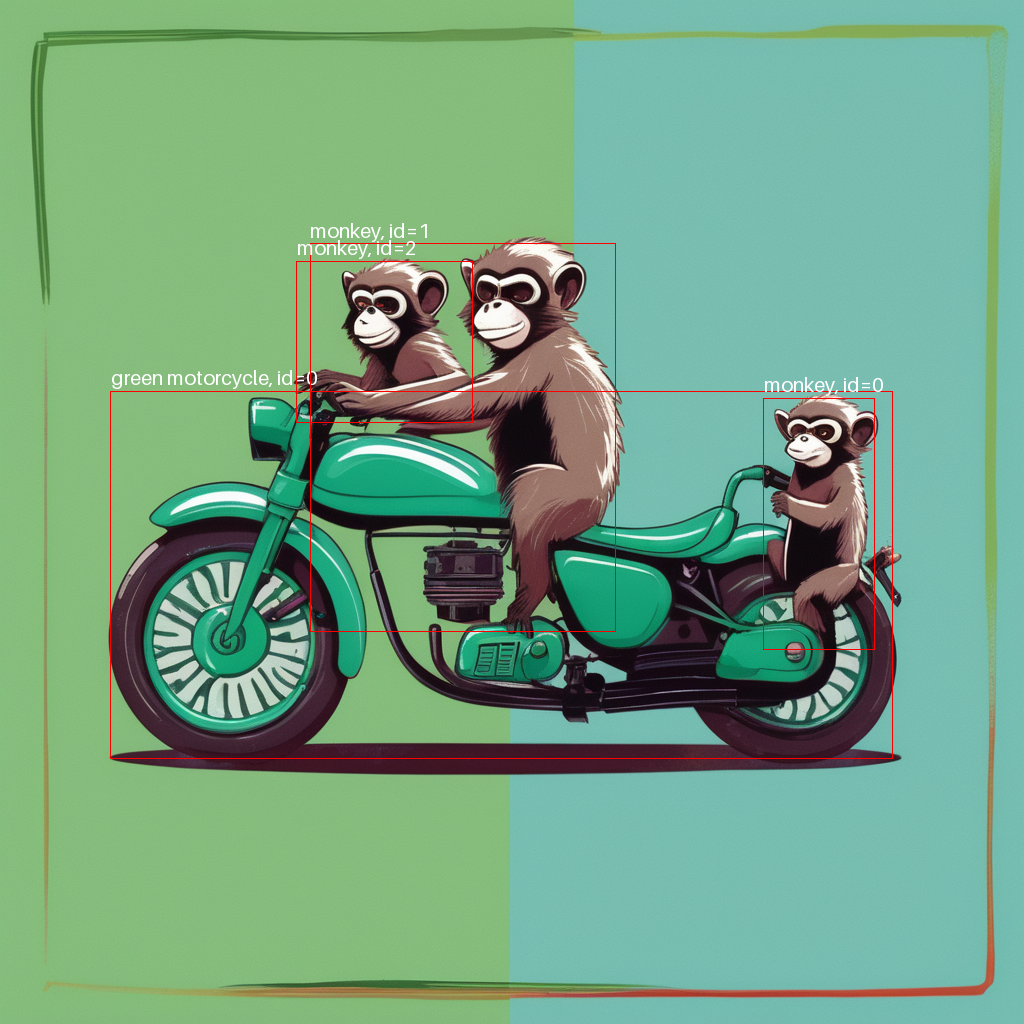

In [22]:
img

In [23]:
handle1.remove()
handle2.remove()
save_aux=False
for name, block in base.unet.named_modules():
    if isinstance(block, (diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, diffusers.models.unet_2d_blocks.UNetMidBlock2DCrossAttn)):
        for attn_name, attn in block.named_modules():
            full_name = name+'.'+attn_name
            if 'attn2' not in attn_name or (attn_greenlist and full_name not in attn_greenlist): 
                continue
            if isinstance(attn, Attention):
                attn.processor = CustomAttentionProcessor(_SG_RES, save_aux)#SelfGuidanceAttnProcessor2_0()
                

base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="output"), with_kwargs=True)
# base.unet.up_blocks[1].resnets[1].conv2.register_forward_hook(partial(stash_to_aux,mode="args", args_idx=0), with_kwargs=True)
base.unet.up_blocks[0].attentions[1].transformer_blocks[3].attn2.register_forward_hook(resave_aux_key)

In [24]:
torch.cuda.empty_cache()

In [25]:
results_new_detection["green motorcycle"][0]

[6, 24, 55, 47]

In [26]:

aux_idx=0
n_img=1 # @param {type:"integer"}
try: processed_aux = {k:torch.utils._pytree.tree_map(lambda x: x[aux_idx:aux_idx+1].repeat_interleave(n_img, 0).cpu(), v) for k,v in aux.items()}
except: pass

sg_edits = {
    "fn": position,
    "words": "green motorcycle",
    "mode": "attn",
    "mode_preserve": ["attn", "last_feats"],
    "weight": 50.0,
    "kwargs": {
        'shift': (0, -15),
        'box_orig': results_new_detection["green motorcycle"][0],

    },
    "weight_preserve": 2.0,
    "tgt": processed_aux,
}

num_inference_steps = 300
sg_loss_rescale = 1000.
sg_grad_wt = 1000.
sg_t_start = 20
sg_t_end = 280
generator = torch.Generator(device=device1).manual_seed(seed)
out = base(prompt=[prompts[2]]*n_img, sg_grad_wt=sg_grad_wt, edit=sg_edits, num_inference_steps=num_inference_steps,
           sg_loss_rescale=sg_loss_rescale, debug=False, sg_t_start=sg_t_start, sg_t_end=sg_t_end, generator=generator, save_aux=save_aux, 
           latents=None, detections=results_new_detection, target_object=("green motorcycle", 0))

  0%|          | 0/300 [00:00<?, ?it/s]

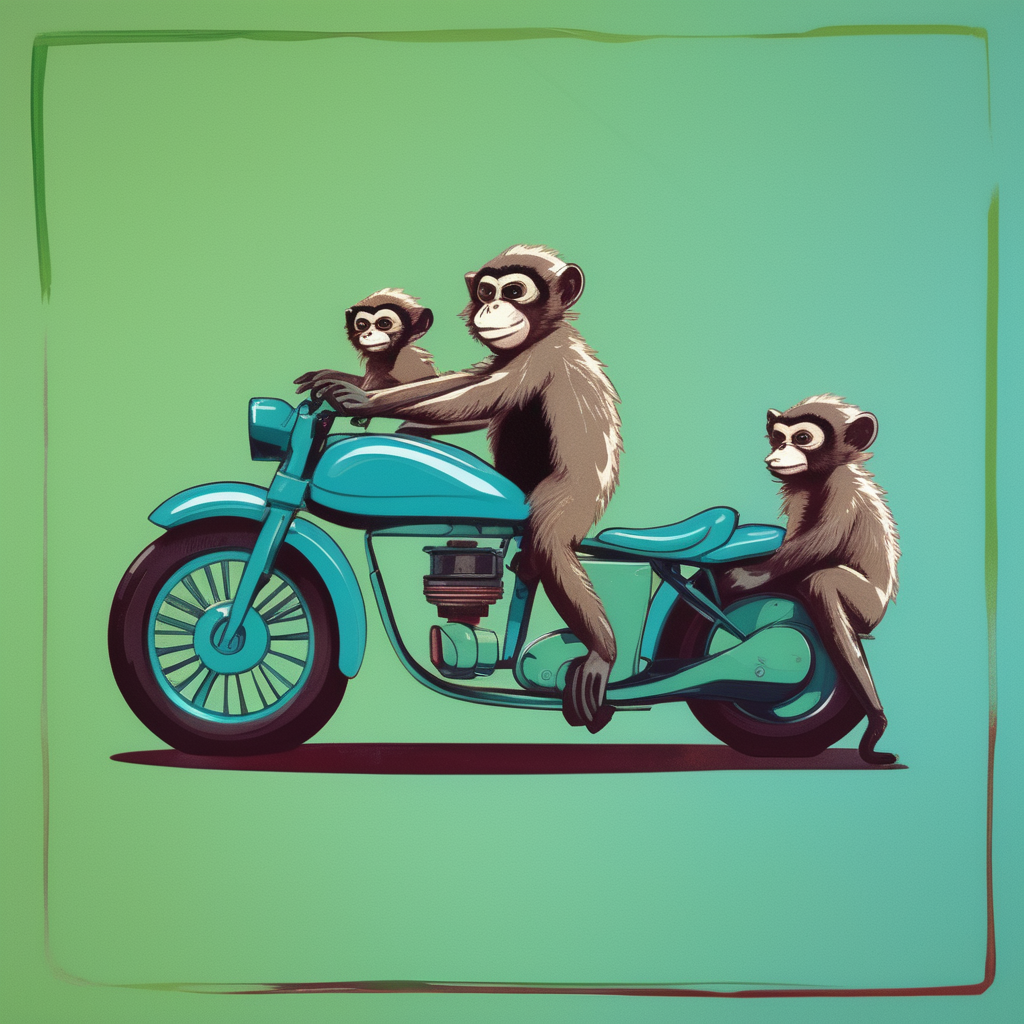

In [27]:
out.images[0]